In [1]:
import torch
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from model import Model
import argparse
import os
from time import time
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
MODEL_PATH = "../models/gen-2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "../inputs/nyu_data/data/nyu2_test"

In [3]:
# Load models
depth_model_0 = Model().to(DEVICE)
depth_model_0.load_state_dict(
    torch.load(f"{MODEL_PATH}/0.pth", map_location=DEVICE, weights_only=True)
)
depth_model_0.eval()

Model(
  (encoder): Encoder(
    (original_model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(

In [4]:
depth_model_0.qconfig = torch.quantization.get_default_qconfig('onednn')
torch.quantization.prepare(depth_model_0, inplace=True)

/home/sidd/.local/lib/python3.10/site-packages/torch/ao/quantization/qconfig.py:257: UserWarning: Default qconfig of oneDNN backend with reduce_range of false may have accuracy issues on CPU without Vector Neural Network Instruction support.
  warnings.warn(


Model(
  (encoder): Encoder(
    (original_model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(
          3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
        )
        (norm0): BatchNorm2d(
          96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
        )
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(
              96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
            )
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(
              96, 192, kerne

In [5]:
image_data = {}

"""
STORAGE FORMAT:
{
    key1 : [image1, depth1],
    key2 : [image2, depth2]
}
"""

# Read images from the given path
image_files = os.listdir(DATA_PATH)

# Classify and store images based on their endings
for image_file in tqdm(image_files, desc="Processing images"):
    image_name, ext = os.path.splitext(image_file)
    key = image_name.split("_")[0]  # Extract the part before '_'

    image_path = os.path.join(DATA_PATH, image_file)

    if image_file.endswith("_depth.png"):
        if key in image_data:
            image_data[key] = (image_data[key][0], cv2.imread(image_path))
        else:
            image_data[key] = (None, cv2.imread(image_path))

    elif image_file.endswith("_colors.png"):
        if key in image_data:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_data[key] = (image, image_data[key][1])
        else:
            image_data[key] = (cv2.imread(image_path), None)

Processing images: 100%|██████████| 1308/1308 [00:08<00:00, 148.37it/s]


In [6]:
with torch.no_grad():
    for _ in range(10):  # Example calibration using 10 batches
        sample_input = torch.rand(1, 3, 480, 640).to(DEVICE)
        depth_model_0(sample_input)

In [7]:
outputs = []

progress_bar = tqdm(image_data.items(), desc="Evaluating", total=len(image_data))

for key, (color_img, ground_truth) in progress_bar:

    image_tensor = (
        torch.from_numpy(cv2.resize(color_img, (640, 480)))
        .float()
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(DEVICE)
    )

    with torch.cuda.amp.autocast(), torch.inference_mode():
        start = time()
        predicted = depth_model_0(image_tensor).cpu().squeeze().numpy()
        end = time()
    
    inference_time = end - start

    progress_bar.set_description(f"Evaluating (Inference Time: {inference_time:.4f} s/image)")

    outputs.append((color_img, ground_truth, 1 - predicted))

Evaluating:   0%|          | 0/654 [00:00<?, ?it/s]/tmp/ipykernel_9352/3663363104.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(), torch.inference_mode():
Evaluating:   0%|          | 0/654 [00:00<?, ?it/s]


RuntimeError: HalfTensor is not supported

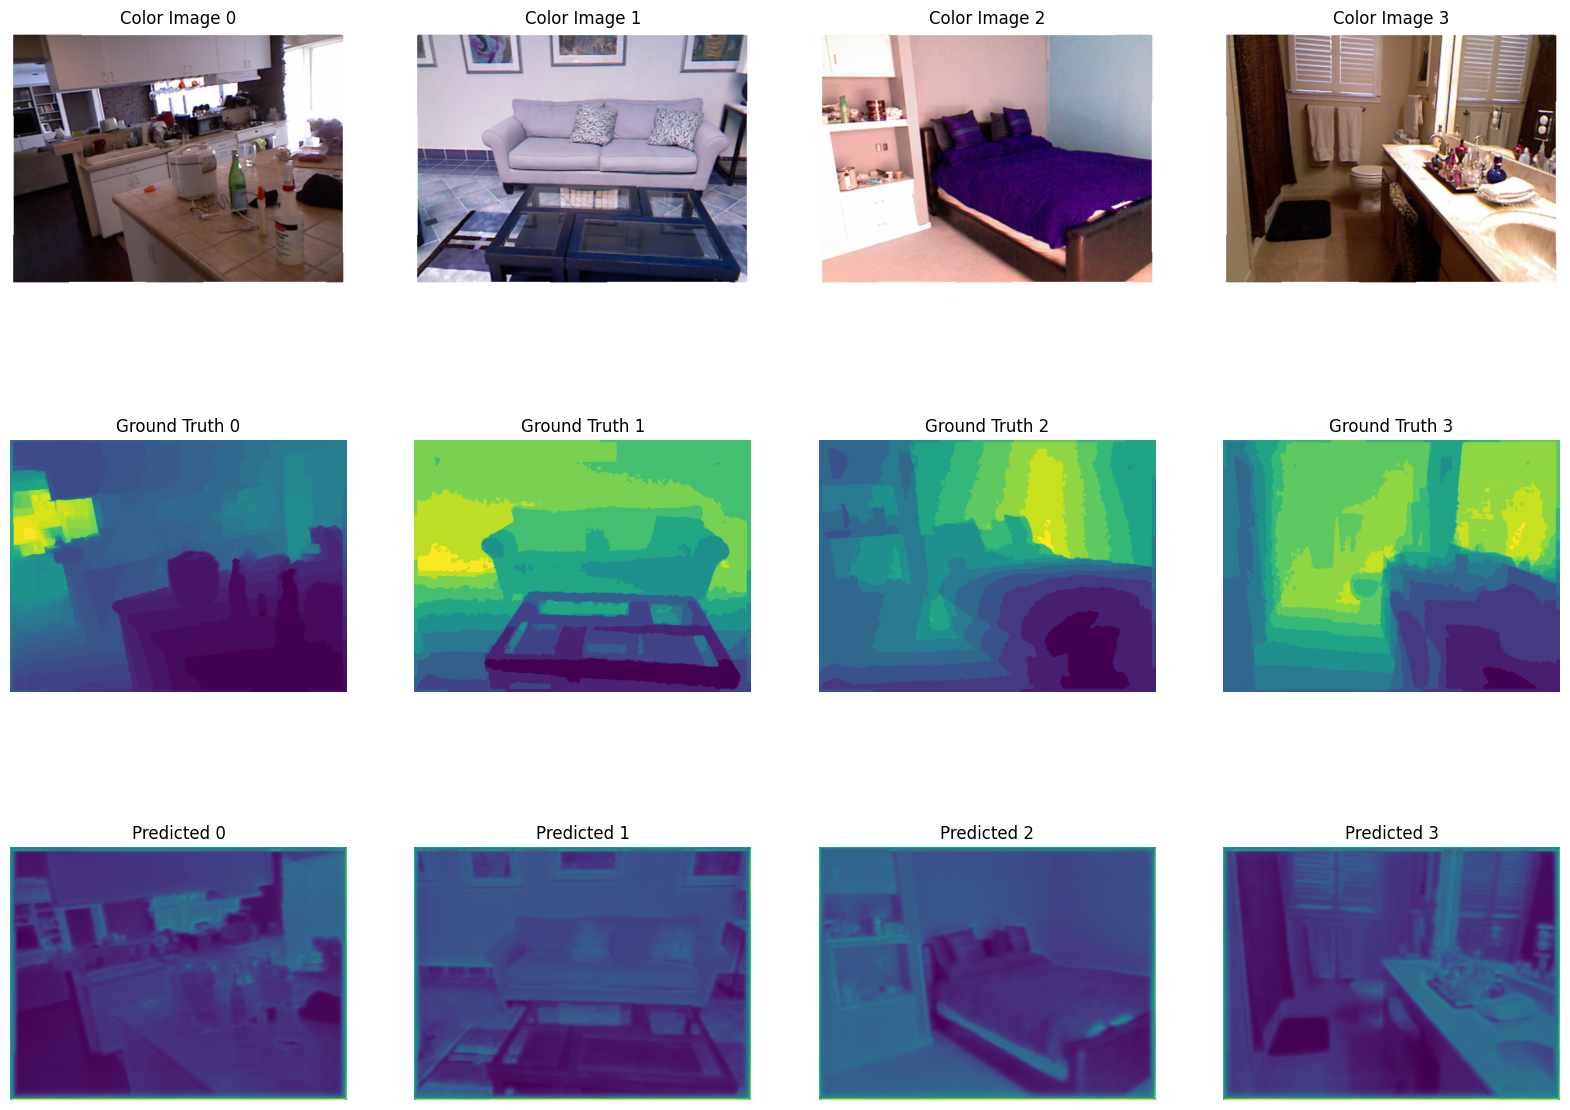

In [19]:
# Create a 3x4 grid for plotting
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, (color_img, ground_truth, predicted) in enumerate(outputs):
    if i == 4:  # Display only the first 12 triplets (adjust based on your grid size)
        break

    # Convert color_img to RGB for matplotlib
    color_img_rgb = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

    # Display color image
    axs[0, i].imshow(color_img_rgb)
    axs[0, i].set_title(f"Color Image {i}")
    axs[0, i].axis('off')

    # Display ground truth image (assumed to be grayscale)
    axs[1, i].imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY), cmap='viridis')
    axs[1, i].set_title(f"Ground Truth {i}")
    axs[1, i].axis('off')

    # Display predicted image (assumed to be grayscale)
    axs[2, i].imshow(1 - predicted, cmap='viridis')
    axs[2, i].set_title(f"Predicted {i}")
    axs[2, i].axis('off')